# Diffeomorphic Image Registration with AIRLAB

This notebook is adapted from https://github.com/airlab-unibas/airlab/blob/master/examples/diffeomorphic_bspline_2d.py

In [17]:
import airlab as al
import numpy as np
import torch

import utility as util

## Load images

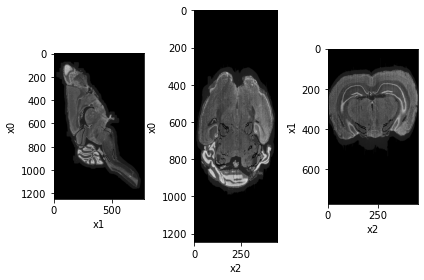

In [18]:
fixed_image = np.load('../data/local/MD589_CH1.npy')
fixed_image = util.normalize_intensity(fixed_image)
util.imshow_midslice(fixed_image)

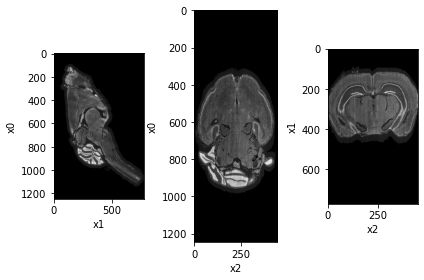

In [20]:
moving_image = np.load('../data/airlab/MD594_CH1_after_linear.npy')
moving_image = util.normalize_intensity(moving_image)
util.imshow_midslice(moving_image)

## Prepare images for registration

In [21]:
dtype = torch.float32
device = torch.device('cpu')
scales = [0.452, 0.452, 20]
fixed_image = torch.tensor(fixed_image, dtype=dtype).to(device)
fixed_image = al.Image(fixed_image, fixed_image.shape, scales, [0, 0, 0])
moving_iamge = torch.tensor(moving_image, dtype=dtype).to(device)
moving_image = al.Image(moving_image, moving_image.shape, scales, [0, 0, 0])

## Configure registration

In [33]:
lr = 1e-2
scales = [[8, 8, 8], [4, 4, 4], [2, 2, 2]]
niter = [128, 16, 2]

fixed_image_pyramid = al.create_image_pyramid(fixed_image, scales)
moving_image_pyramid = al.create_image_pyramid(moving_image, scales)

fixed_image_ds = fixed_image_pyramid[-2]
moving_image_ds = moving_image_pyramid[-2]

In [34]:
import time

start = time.time()

regularisation_weight = [1, 2, 4]
sigma = [[8, 8, 8], [4, 4, 4], [2, 2, 2]]
for level, (mov_im, fix_im) in enumerate(zip(moving_image_pyramid, fixed_image_pyramid)):
    if level == len(moving_image_pyramid) - 1:
        break

    print('level', level)
    registration = al.PairwiseRegistration(verbose=True)

    transformation = al.transformation.pairwise.BsplineTransformation(
        mov_im.size,
        sigma=sigma[level],
        order=3,
        diffeomorphic=True
    )
    if level > 0:
        constant_flow = al.transformation.utils.upsample_displacement(
            constant_flow,
            mov_im.size,
            interpolation="linear"
        )
        transformation.set_constant_flow(constant_flow)
    registration.set_transformation(transformation)

    image_loss = al.loss.pairwise.MSE(fix_im, mov_im)
    registration.set_image_loss([image_loss])

    regulariser = al.regulariser.displacement.DiffusionRegulariser(mov_im.spacing)
    regulariser.set_weight(regularisation_weight[level])
    registration.set_regulariser_displacement([regulariser])

    optimizer = torch.optim.Adam(transformation.parameters())
    registration.set_optimizer(optimizer)
    registration.set_number_of_iterations(niter[level])

    registration.start()

    constant_flow = transformation.get_flow()

end = time.time()
print((end - start) / 60, 'min')

level 0
0 mse: 0.0019295443541801176 L2: 0.0 
1 mse: 0.001913699849714033 L2: 4.346962327872461e-07 
2 mse: 0.0018551360425315183 L2: 1.4672921224700985e-06 
3 mse: 0.001795956227869201 L2: 3.0249470910348464e-06 
4 mse: 0.0017368772713545163 L2: 5.080642040411476e-06 
5 mse: 0.001674760383421036 L2: 7.586309493490262e-06 
6 mse: 0.0016108721618517828 L2: 1.0488917723705526e-05 
7 mse: 0.001552022102116488 L2: 1.3735954780713655e-05 
8 mse: 0.0014998966848728797 L2: 1.7261052562389523e-05 
9 mse: 0.0014519646427835254 L2: 2.100570418406278e-05 
10 mse: 0.0014081215923642824 L2: 2.491297163942363e-05 
11 mse: 0.0013676392735385034 L2: 2.89271029032534e-05 
12 mse: 0.001330865776890326 L2: 3.299981472082436e-05 
13 mse: 0.0012963016307177041 L2: 3.709573866217397e-05 
14 mse: 0.001263306168232336 L2: 4.11838736908976e-05 
15 mse: 0.0012323366005777751 L2: 4.5237047743285075e-05 
16 mse: 0.0012034719325560842 L2: 4.923175947624259e-05 
17 mse: 0.0011767156998131517 L2: 5.3145267884247005e

## Examine results

In [35]:
transformation

BsplineTransformation()

In [36]:
displacement = transformation.get_displacement()
warped_image = al.transformation.utils.warp_image(moving_image_ds, displacement)
np.save('../data/airlab/MD594_CH1_after_bspline.npy', warped_image.image[0,0].numpy())

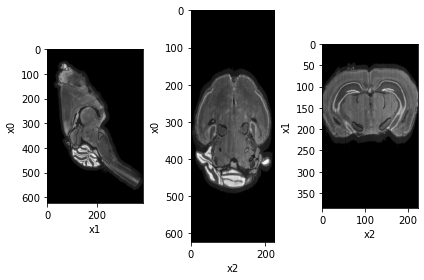

In [37]:
util.imshow_midslice(moving_image_ds.image[0,0].numpy())

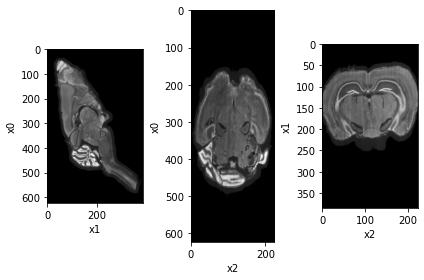

In [38]:
util.imshow_midslice(warped_image.image[0,0].numpy())

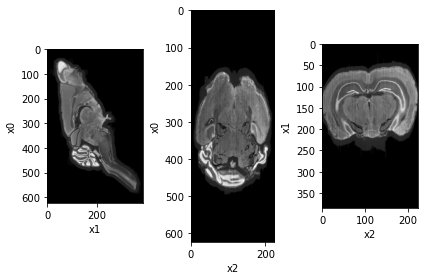

In [39]:
util.imshow_midslice(fixed_image_ds.image[0,0].numpy())